# Enriching covid data with region information
### Data Engineering Capstone Project

#### Project Summary
Enrich a covid dataset with information about city, city micro and macro region using PySpark and Pandas in order now we can also make analysis from those new region areas and maybe help city halls, state overnment or even the federal government to better distribute resources (money, health equipments, vaccines and so on) 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [103]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, unix_timestamp, from_unixtime, udf, sum as _sum, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.types import DateType
from pyspark.sql import Window
import sys
import datetime


# because an issue when creating spark session-> Exception: Java gateway process exited before sending its port number
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"

os.environ['AWS_ACCESS_KEY_ID']=""
os.environ['AWS_SECRET_ACCESS_KEY']=""

In [104]:
# Create Spark Session
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 

1. This project intend to get relations between the covid cases and cities regions in Brazil.
1. It will use 2 datasources, one which contain covid cases and another focused on city information to enrich the fisrt and get better insights.
1. Will use the PySpark to process and handle data.

#### Describe and Gather Data 

1. **Covid data:** This dataset is from Kaggle.
   It's basically a csv file where we can find the data about covid cases and deaths in Brazil, by date and city.
   https://www.kaggle.com/rafaelherrero/covid19-brazil-full-cases-17062021
2. **Brazil city information:** In this dataset is where we can find more information about the city as the city state,
   macro and micro region. https://www.ibge.gov.br/explica/codigos-dos-municipios.php#PR


In [105]:
# Read in the data here
df = spark.read.format("csv").option("header", "true").load("caso_full.csv")

In [106]:
df.limit(5).toPandas()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401,2020-03-17,202012,413418,407319,False,False,3,0.72566,2020-03-17,0.0000,0,1,city,AC,3,0
1,None,12,2020-03-17,202012,894470,881935,False,False,3,0.33539,2020-03-17,0.0000,0,1,state,AC,3,0
2,Rio Branco,1200401,2020-03-18,202012,413418,407319,False,False,3,0.72566,2020-03-18,0.0000,0,2,city,AC,0,0
3,None,12,2020-03-18,202012,894470,881935,False,False,3,0.33539,2020-03-18,0.0000,0,2,state,AC,0,0
4,Rio Branco,1200401,2020-03-19,202012,413418,407319,False,False,4,0.96754,2020-03-19,0.0000,0,3,city,AC,1,0


In [107]:
df.count()

2258704

In [108]:
df_cities_region = spark.read.format("csv").option("delimiter",";").option("header", "true").load("BRAZIL_CITIES_REGION.csv")

In [109]:
df_cities_region.limit(5).toPandas()

,UF,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município
0,11,Rondônia,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste
1,11,Rondônia,2,Leste Rondoniense,6,Cacoal,379,1100379,Alto Alegre dos Parecis
2,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,403,1100403,Alto Paraíso
3,11,Rondônia,2,Leste Rondoniense,5,Alvorada D'Oeste,346,1100346,Alvorada D'Oeste
4,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
1. Perform the cast in order to have the right types for each field
1. Remove null values from some important fields (city, city_ibge_code..)

In [110]:
def perform_column_cast(dataframe, col_name, new_type):
    """
        Function to cast a column given a dataframe
        @param dataframe: the dataframe where the column is
        @param col_name: to be cast
        @param new_type: the new column type
        @return The new datafram with the column already cast
    """
    return dataframe.withColumn(col_name, dataframe[col_name].cast(new_type))

def remove_null_rows(dataframe, col_name):
    """
        Function to filter a row given a column case it is not null
        @param dataframe: the dataframe where the column is
        @param col_name: column name
        @return The new datafram with the column already cast
    """
    return dataframe.filter(col(col_name).isNotNull())
    

#### Cleaning the Covid cases dataset

In [111]:
# Performing cleaning tasks here
df.printSchema()

root
 |-- city: string (nullable = true)
 |-- city_ibge_code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- epidemiological_week: string (nullable = true)
 |-- estimated_population: string (nullable = true)
 |-- estimated_population_2019: string (nullable = true)
 |-- is_last: string (nullable = true)
 |-- is_repeated: string (nullable = true)
 |-- last_available_confirmed: string (nullable = true)
 |-- last_available_confirmed_per_100k_inhabitants: string (nullable = true)
 |-- last_available_date: string (nullable = true)
 |-- last_available_death_rate: string (nullable = true)
 |-- last_available_deaths: string (nullable = true)
 |-- order_for_place: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- new_confirmed: string (nullable = true)
 |-- new_deaths: string (nullable = true)



In [112]:
# Count null collumns to explore a little the dataset
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,12451,8250,0,0,8250,8250,0,0,0,23769,0,0,0,0,0,0,0,0


In [113]:
#Give the right type for columns
df_cleaned = df
df_cleaned = perform_column_cast(df_cleaned, "city_ibge_code", 'int')
df_cleaned = perform_column_cast(df_cleaned, "new_confirmed", 'int')
df_cleaned = perform_column_cast(df_cleaned, "new_deaths", 'int')
df_cleaned = perform_column_cast(df_cleaned, "order_for_place", 'int')
df_cleaned = perform_column_cast(df_cleaned, "is_last", 'boolean')
df_cleaned = perform_column_cast(df_cleaned, "is_repeated", 'boolean')
df_cleaned = perform_column_cast(df_cleaned, "date", DateType())


#remove rows where we have the city as null
df_cleaned = remove_null_rows(df_cleaned, 'city')
df_cleaned = remove_null_rows(df_cleaned, 'city_ibge_code')


df_cleaned.printSchema()

root
 |-- city: string (nullable = true)
 |-- city_ibge_code: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- epidemiological_week: string (nullable = true)
 |-- estimated_population: string (nullable = true)
 |-- estimated_population_2019: string (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- is_repeated: boolean (nullable = true)
 |-- last_available_confirmed: string (nullable = true)
 |-- last_available_confirmed_per_100k_inhabitants: string (nullable = true)
 |-- last_available_date: string (nullable = true)
 |-- last_available_death_rate: string (nullable = true)
 |-- last_available_deaths: string (nullable = true)
 |-- order_for_place: integer (nullable = true)
 |-- place_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)



In [114]:
# Checking fot the number of cities
cities_number = df_cleaned.filter((df_cleaned.place_type=='city') & ~(df_cleaned.city.isNull())).select('city').distinct().count()
print("Numbers of cities in covid dataset: ", cities_number)

Numbers of cities in covid dataset:  5297


In [115]:
# Checking the states number
states_number = df_cleaned.select('state').distinct().count()
print("Numbers of states in covid dataset: ", states_number)

Numbers of states in covid dataset:  27


In [116]:
df_sum = df_cleaned.filter(col('place_type')=='city').groupBy("date").agg(_sum("new_confirmed").alias("confirmed_cases"), \
                                                                          _sum("new_deaths").alias("deaths")).sort('date').toPandas()

In [117]:
df_sum.confirmed_cases.values

array([     1,      0,      0,      1,      0,      0,      0,      0,
            1,      4,      2,      9,      6,      0,      4,     14,
           45,      7,     37,     19,    121,     46,    185,    119,
          233,    206,    197,    247,    259,    732,    396,    483,
          295,    312,    577,   1154,   1093,   1157,   1102,   1111,
         1090,    828,   1816,   2151,   1907,   1754,   1058,   1469,
         1386,   1921,   3221,   2099,   3274,   2747,   1863,   1847,
         2757,   2757,   3861,   2906,   5075,   4897,   4197,   6201,
         6093,   7382,   5444,   4980,   4212,   6911,   7132,   9864,
        10753,   9636,  10823,   6194,   6251,   9548,  11563,  13988,
        15159,  14052,   7642,  14157,  13184,  21313,  19221,  21951,
        18126,  14266,  12782,  16092,  20205,  28074,  26701,  32375,
        13115,  14986,  31509,  25665,  31617,  31701,  23834,  18044,
        17429,  30430,  33970,  27855,  25307,  20600,  17305,  23922,
      

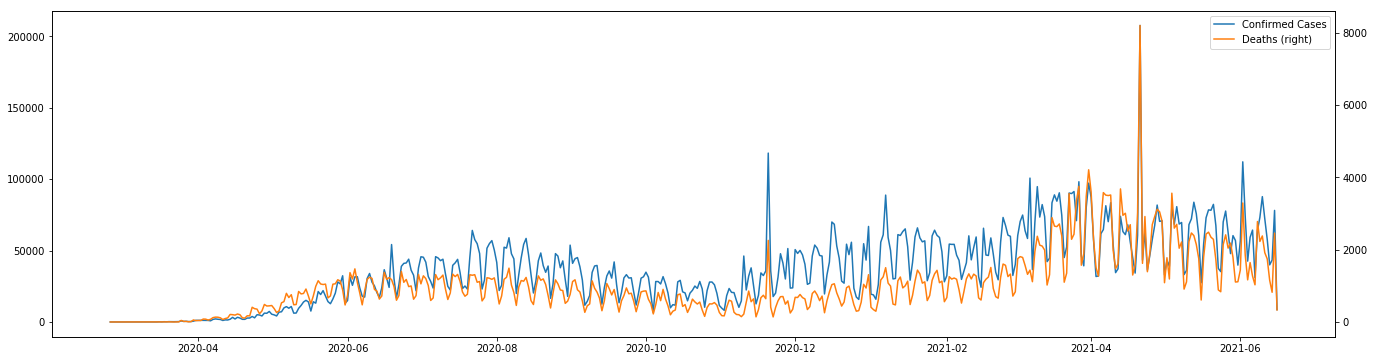

In [118]:
# Exploring the data in order to check for missing values, wrong values or  data
confirmed_cases = df_sum.confirmed_cases.values
deaths = df_sum.deaths.values
index = df_sum.date.values
df_plot = pd.DataFrame({'Confirmed Cases': confirmed_cases,'Deaths': deaths}, index=index)
df_plot['Confirmed Cases'].plot(figsize=(23, 6), legend=True)
df_plot['Deaths'].plot(secondary_y=True, legend=True)

In [119]:
# Getting one city sample in order to check the data
df_cleaned.filter(df_cleaned.city=='Amparo').sort(df_cleaned.order_for_place.desc()).limit(10).toPandas()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Amparo,3501905,2021-06-16,202124,72677,72195,False,True,5728,7881.44805,2021-06-15,0.0225,129,432,city,SP,0,0
1,Amparo,3501905,2021-06-15,202124,72677,72195,True,False,5728,7881.44805,2021-06-15,0.0225,129,431,city,SP,106,0
2,Amparo,3501905,2021-06-14,202124,72677,72195,False,True,5622,7735.59723,2021-06-13,0.0229,129,430,city,SP,0,0
3,Amparo,3501905,2021-06-13,202124,72677,72195,False,False,5622,7735.59723,2021-06-13,0.0229,129,429,city,SP,29,0
4,Amparo,3501905,2021-06-12,202123,72677,72195,False,False,5593,7695.69465,2021-06-12,0.0231,129,428,city,SP,33,0
5,Amparo,3501905,2021-06-11,202123,72677,72195,False,False,5560,7650.28826,2021-06-11,0.0232,129,427,city,SP,59,0
6,Amparo,3501905,2021-06-10,202123,72677,72195,False,False,5501,7569.10715,2021-06-10,0.0235,129,426,city,SP,51,0
7,Amparo,3501905,2021-06-09,202123,72677,72195,False,False,5450,7498.93364,2021-06-09,0.0237,129,425,city,SP,0,0
8,Amparo,3501905,2021-06-08,202123,72677,72195,False,False,5450,7498.93364,2021-06-08,0.0237,129,424,city,SP,49,0
9,Amparo,3501905,2021-06-07,202123,72677,72195,False,False,5401,7431.51203,2021-06-07,0.0239,129,423,city,SP,6,0


#### Cleaning the Cities Region dataset

In [120]:
df_cities_region.printSchema()

root
 |-- UF: string (nullable = true)
 |-- Nome_UF: string (nullable = true)
 |-- Mesorregião Geográfica: string (nullable = true)
 |-- Nome_Mesorregião: string (nullable = true)
 |-- Microrregião Geográfica: string (nullable = true)
 |-- Nome_Microrregião: string (nullable = true)
 |-- Município: string (nullable = true)
 |-- Código Município Completo: string (nullable = true)
 |-- Nome_Município: string (nullable = true)



In [121]:
#Rename columsn to english
df_cities_region_cleaned = df_cities_region
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("UF", "code_state")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Nome_UF", "state_name")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Mesorregião Geográfica", "code_macro_region")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Nome_Mesorregião", "macro_region_name")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Microrregião Geográfica", "code_micro_region")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Nome_Microrregião", "micro_region_name")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Município", "code_city")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Código Município Completo", "city_ibge_code")
df_cities_region_cleaned = df_cities_region_cleaned.withColumnRenamed("Nome_Município", "city_name")

# Cast some fields
df_cities_region_cleaned = perform_column_cast(df_cities_region_cleaned, "city_ibge_code", 'int')
df_cities_region_cleaned = perform_column_cast(df_cities_region_cleaned, "code_city", 'int')
df_cities_region_cleaned = perform_column_cast(df_cities_region_cleaned, "code_micro_region", 'int')
df_cities_region_cleaned = perform_column_cast(df_cities_region_cleaned, "code_macro_region", 'int')

#Print to check the changes
df_cities_region_cleaned.printSchema()

root
 |-- code_state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- code_macro_region: integer (nullable = true)
 |-- macro_region_name: string (nullable = true)
 |-- code_micro_region: integer (nullable = true)
 |-- micro_region_name: string (nullable = true)
 |-- code_city: integer (nullable = true)
 |-- city_ibge_code: integer (nullable = true)
 |-- city_name: string (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The model will be basically divided in three tables using a **snowflake** schema.
In this way we can keep each entity in a table, it's better to enrich and we avoid a lot of repeated data(as the city was in the original dataset).
For the queries we can use the 'city_ibge_code' (used here a ForeignKey) to join events with the city and all information about that. The same for the date using the 'date' field.

1. Cities
1. Events
1. Calendar<br>

<img src="schema.png">

#### 3.2 Mapping Out Data Pipelines
The data was cleaned previously, now we will insert in to parquet and make a join to enrich the city data with more information

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

In [122]:
#output folder to save parquest files
output_folder = "result_tables/"

def save_to_parquet(dataframe, parquet_file_path, partition_columns, mode="overwrite"):
    """
        Method to save a dataframe to a parquet file
        @param dataframe: The dataframe which the data will be saved on the parquet file
        @param parquet_file_path: parquet file path
        @param partition_columns: list of column names which will be used for the partition of parquet files
        @return none
    """
    dataframe.write.parquet(parquet_file_path, partitionBy=partition_columns, mode=mode)
    

In [123]:
# Make the calendar table, getting the date and breaking down in more specific columns
df_cal = df_cleaned.select(col('date')).withColumn('date', df_cleaned.date.cast(DateType())).distinct()
df_cal = df_cal.withColumn('day', dayofmonth('date'))
df_cal = df_cal.withColumn('week', weekofyear('date'))
df_cal = df_cal.withColumn('month', month('date'))
df_cal = df_cal.withColumn('year', year('date'))
df_cal = df_cal.withColumn('weekday', dayofweek('date'))

partition_columns = ['year', 'month', 'week']

save_to_parquet(df_cal, output_folder + "calendar", partition_columns)

In [124]:
# Join covid cases with city region info
df_all = df_cleaned.join(df_cities_region_cleaned, df_cleaned.city_ibge_code ==  df_cities_region_cleaned.city_ibge_code, "inner")

df_all = df_all.drop(df_cleaned.city_ibge_code)

In [125]:
df_all.limit(5).toPandas()

,city,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,...,new_deaths,code_state,state_name,code_macro_region,macro_region_name,code_micro_region,micro_region_name,code_city,city_ibge_code,city_name
0,Rio Branco,2020-03-17,202012,413418,407319,False,False,3,0.72566,2020-03-17,...,0,12,Acre,2,Vale do Acre,4,Rio Branco,401,1200401,Rio Branco
1,Rio Branco,2020-03-18,202012,413418,407319,False,False,3,0.72566,2020-03-18,...,0,12,Acre,2,Vale do Acre,4,Rio Branco,401,1200401,Rio Branco
2,Rio Branco,2020-03-19,202012,413418,407319,False,False,4,0.96754,2020-03-19,...,0,12,Acre,2,Vale do Acre,4,Rio Branco,401,1200401,Rio Branco
3,Rio Branco,2020-03-20,202012,413418,407319,False,False,7,1.69320,2020-03-20,...,0,12,Acre,2,Vale do Acre,4,Rio Branco,401,1200401,Rio Branco
4,Rio Branco,2020-03-21,202012,413418,407319,False,False,11,2.66075,2020-03-21,...,0,12,Acre,2,Vale do Acre,4,Rio Branco,401,1200401,Rio Branco


In [126]:
df_all.printSchema()

root
 |-- city: string (nullable = true)
 |-- date: date (nullable = true)
 |-- epidemiological_week: string (nullable = true)
 |-- estimated_population: string (nullable = true)
 |-- estimated_population_2019: string (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- is_repeated: boolean (nullable = true)
 |-- last_available_confirmed: string (nullable = true)
 |-- last_available_confirmed_per_100k_inhabitants: string (nullable = true)
 |-- last_available_date: string (nullable = true)
 |-- last_available_death_rate: string (nullable = true)
 |-- last_available_deaths: string (nullable = true)
 |-- order_for_place: integer (nullable = true)
 |-- place_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- code_state: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- code_macro_region: integer (nullable = true)
 |-- macro_region_name: string (null

In [127]:
df_city = df_all.select(['city_ibge_code', 'city_name', 'code_city', 'state', 'code_state', 'state_name', 
                         'code_macro_region', 'macro_region_name', 'code_micro_region', 
                         'micro_region_name', 'estimated_population', 'estimated_population_2019']).distinct()
df_city.limit(10).toPandas()

,city_ibge_code,city_name,code_city,state,code_state,state_name,code_macro_region,macro_region_name,code_micro_region,micro_region_name,estimated_population,estimated_population_2019
0,2302800,Canindé,2800,CE,23,Ceará,2,Norte Cearense,12,Canindé,77244,76997
1,3119302,Coromandel,19302,MG,31,Minas Gerais,5,Triângulo Mineiro/Alto Paranaíba,19,Patrocínio,27966,27974
2,3103306,Aracitaba,3306,MG,31,Minas Gerais,12,Zona da Mata,65,Juiz de Fora,2059,2063
3,3148806,Pedra do Anta,48806,MG,31,Minas Gerais,12,Zona da Mata,62,Viçosa,3005,3052
4,5004007,Glória de Dourados,4007,MS,50,Mato Grosso do Sul,4,Sudoeste de Mato Grosso do Sul,11,Iguatemi,9950,9965
5,5108501,Vera,8501,MT,51,Mato Grosso,1,Norte Mato-grossense,7,Sinop,11402,11309
6,2602506,Brejinho,2506,PE,26,Pernambuco,1,Sertão Pernambucano,3,Pajeú,7488,7487
7,2204709,Inhuma,4709,PI,22,Piauí,2,Centro-Norte Piauiense,6,Valença do Piauí,15319,15308
8,2202737,Coivaras,2737,PI,22,Piauí,2,Centro-Norte Piauiense,3,Teresina,4032,4020
9,2209500,Santo Inácio do Piauí,9500,PI,22,Piauí,4,Sudeste Piauiense,15,Alto Médio Canindé,3803,3798


In [128]:
#save cities info to parquet 
partition_columns = ['state', 'city_ibge_code']

save_to_parquet(df_city, output_folder + "cities", partition_columns)

In [129]:
df_city.filter(col('macro_region_name')=='Campinas').count()

49

In [130]:
#Save covid events to parquet
df_events = df_all.filter(df_all.macro_region_name=='Campinas').select(col('date'), col('city_ibge_code'), col('new_deaths'), col('new_confirmed'))

partition_columns = ['date', 'city_ibge_code']
save_to_parquet(df_events, output_folder + "events", partition_columns)

#### 4.2 Data Quality Checks
The data quality will check for:
 * Integrity of the table schemas
 * Verify for empty tables

In [131]:
# Perform quality checks here

def run_quality_checks(table_schemas):
    """
        Method to run the quality checks against the tables
        
        @Param: table_schemas -> Dict containing the table name and the collums
        @return: List of issues
    """

    tables_to_check = table_schemas.keys()
    failed_list=[]
    for table in tables_to_check:
        parquetFile = spark.read.parquet(output_folder + table)

        # Check for the empty parquet file
        if parquetFile.count() <= 0:
            failed_list.append("Table {} is empty.")
        # Compare the schema to check the table integrity
        if len((set(parquetFile.columns) ^ set(table_schemas.get(table))) | (set(parquetFile.columns) ^ set(table_schemas.get(table)))) > 0:
            failed_list.append("Table '{}' has discrepancies in the schema.".format(table))
            
    return failed_list

In [132]:
# Dict with the table name and it columns
table_schemas = {
    'calendar': ['date', 'day', 'weekday', 'year', 'month', 'week'],
    'cities':   ['city_ibge_code', 'city_name', 'code_city', 'state', 'code_state', 'state_name', 
                 'code_macro_region', 'macro_region_name', 'code_micro_region', 
                 'micro_region_name', 'estimated_population', 'estimated_population_2019'],
    'events':   ['new_deaths', 'new_confirmed', 'date', 'city_ibge_code']
}
            
failed_list = run_quality_checks(table_schemas)

if len(failed_list) > 0:
    print("We have some erros: ", failed_list)
else:
    print("Quality Check passed")

Quality Check passed


#### 4.3 Data dictionary 

#### Calendar table

| Column  |Description|
|---------|------------|
| date    |The date the event happend (yyyy-mm-dd)|
| day     |Day (1-31)|
| week    |Week (1-53)|
| month   |Month (1-12)|
| year    |Year (0-9999)|
| weekday | Weekday (1-7)|


#### Cities table

| Column  |Description|
|---------|------------|
| city_ibge_code    |The code for the IBGE|
| city_name     |City name|
| code_city    |Code city by IBGE code|
| state   |State Acronym (2 chars)|
| code_state    |Code for the state by IBGE|
| state_name | State name|
| code_macro_region | Macro region code by IBGE |
| macro_region_name | Macro region mae|
| code_micro_region | Code for the micro region by IBGE|
| micro_region_name | Micro region mae|
| estimated_population | Estimated city population in year 2020 |
| estimated_population_2019 | Estimated city population in year 2019 |



#### Events table

|Column  |Description|
|---------|------------|
| date    |The date the event happend (yyyy-mm-dd)|
| city_ibge_code     |Code by IBGE to identify the city|
| new_deaths    |New deaths on the city at the date|
| new_confirmed   | New covid confirmed cases on the city at the date|


### 5 Data Analysis

Lets focus the investigation in one macro region, in this case we chose a macro region called **Campinas**, a big region in **São Paulo** state.

In [133]:
events_pqt_file = spark.read.parquet(output_folder + "events")
events_pqt_file.createOrReplaceTempView("events")


cities_pqt_file = spark.read.parquet(output_folder + "cities")
cities_pqt_file.createOrReplaceTempView("cities")


by_city = spark.sql("""
SELECT city_name, sum(new_confirmed) as confirmed_cases, sum(new_deaths) deaths, MAX(estimated_population) as pop
FROM events e
JOIN cities c ON c.city_ibge_code = e.city_ibge_code
WHERE c.macro_region_name = 'Campinas'
GROUP BY 1
""")
df_by_city = by_city.toPandas()

In [134]:
df_by_city['cases_per_pop'] = df_by_city['confirmed_cases'] / pd.to_numeric(df_by_city['pop'])

On the chart below we can see all the cities from Campinas region.
We divided the number of cases by the number of ihanbitants for each city and as we can see on the chart the city which has more cases and maybe need more resources to treat them is Paulínia city followed by Holambra city

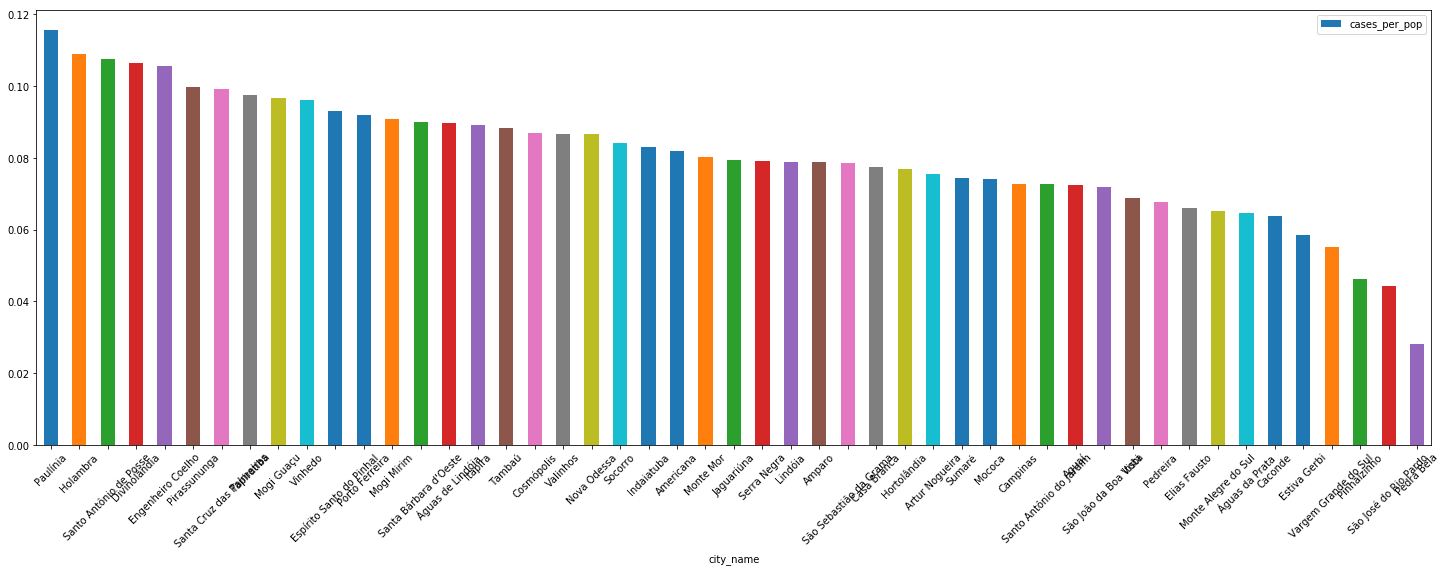

In [135]:
ax = df_by_city.sort_values(['cases_per_pop'], ascending = False).plot.bar(x='city_name', y='cases_per_pop', rot=45, figsize=(25,8))

In [136]:
 df_by_city.sort_values(['cases_per_pop'],  ascending = False)[:5][['city_name', 'confirmed_cases', 'pop', 'cases_per_pop']]

,city_name,confirmed_cases,pop,cases_per_pop
43,Paulínia,12939,112003,0.115524
16,Holambra,1665,15272,0.109023
6,Santo Antônio de Posse,2532,23529,0.107612
46,Divinolândia,1180,11086,0.106441
36,Engenheiro Coelho,2247,21249,0.105746


Here we see the number of deaths divided per number of inhabitants.
Now Divinolândia city is the first

In [137]:
df_by_city['deaths_per_pop'] = (df_by_city['deaths'] / pd.to_numeric(df_by_city['pop'])) * 100
df_by_city['deaths_per_cases'] = (df_by_city['deaths'] / pd.to_numeric(df_by_city['confirmed_cases'])) * 100


df_by_city.sort_values(['deaths_per_pop'],  ascending = False)[:5][['city_name', 'confirmed_cases', 'pop', 'deaths_per_pop', 'deaths_per_cases']]

,city_name,confirmed_cases,pop,deaths_per_pop,deaths_per_cases
46,Divinolândia,1180,11086,0.414938,3.898305
33,Mogi Mirim,8512,93650,0.300053,3.301222
14,Santa Bárbara d'Oeste,17469,194390,0.298369,3.320167
29,Itapira,6702,75234,0.292421,3.282602
22,Campinas,88340,1213792,0.288600,3.965361


### Analyzing the 10 most fatal cities


#### By population
The chart below we can see the 10 most cities where the percentage of deaths per number of total population are the highest.
We can see the Divinolância city has a number which differ too much from the second city. May it need to be a attention point.

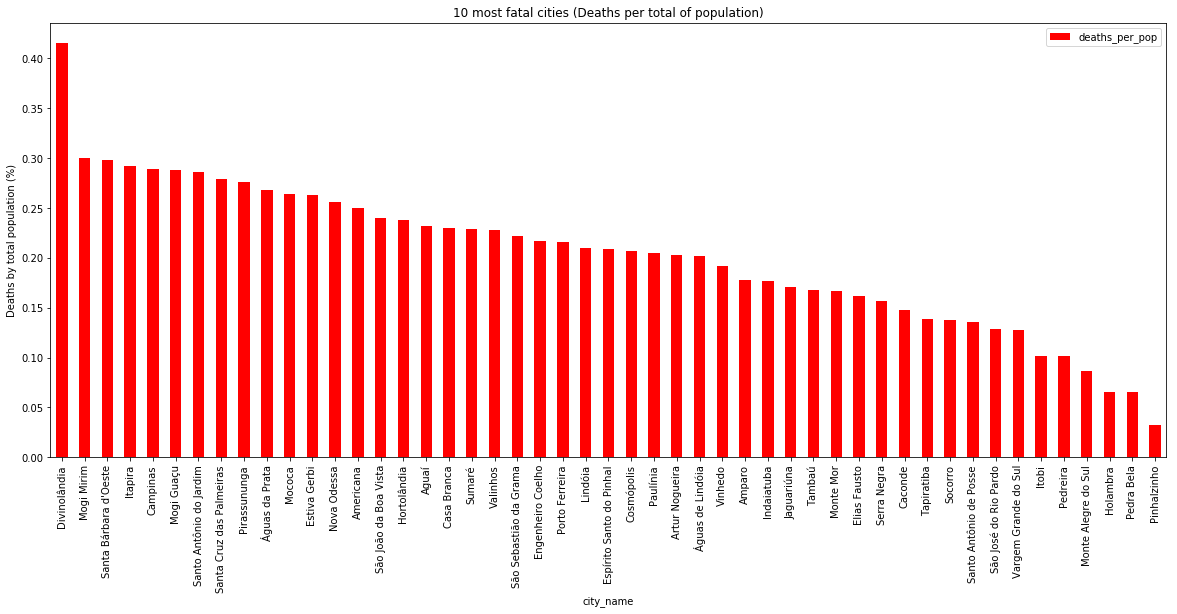

In [138]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

ax.set_ylabel('Deaths by total population (%)')
ax.set_title('10 most fatal cities (Deaths per total of population)')
ax.set_xlabel('Cities')
ax.legend()

df_by_city.sort_values(['deaths_per_pop'],  ascending = False).plot(x='city_name', y='deaths_per_pop', kind='bar', color='red', ax=ax)

plt.show()

#### By cases
Here we can see the deaths per confirmed cases and Estiva gerbi is the first one where we have the highet percentage of deaths by the confirmed cases, by the  top 5 has a significant difference from the 6th.
Maybe something become the cases there more fatal and it could be a less hospiptal infrastructure, delay on the covid patient diagnostic and treatment start.

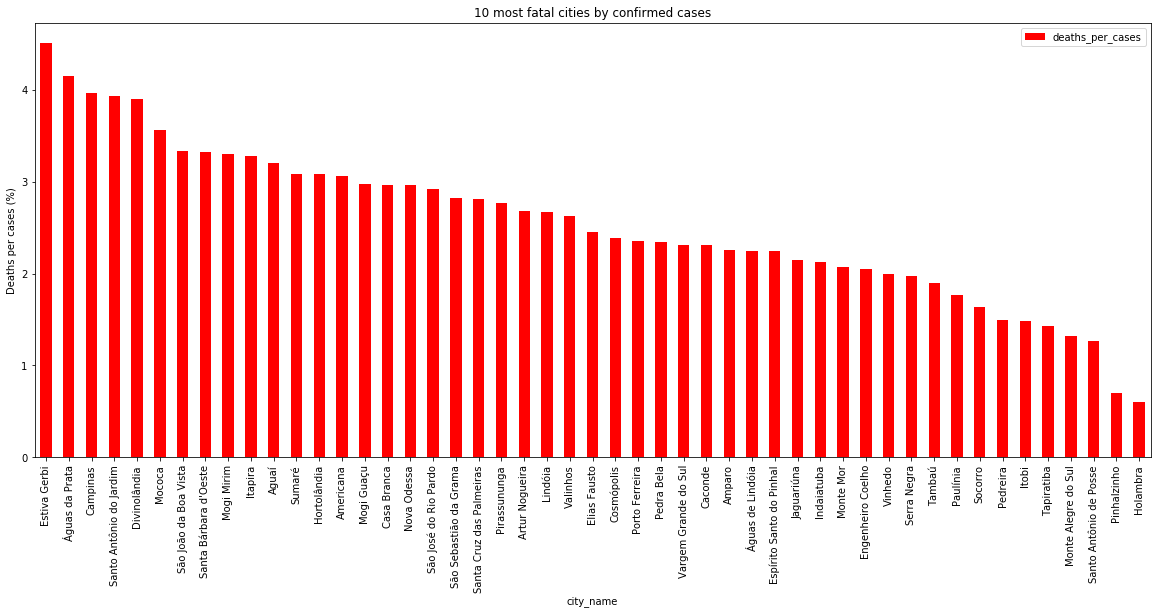

In [139]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111)

ax.set_ylabel('Deaths per cases (%)')
ax.set_title('10 most fatal cities by confirmed cases')
ax.set_xlabel('Cities')
ax.legend()

df_by_city.sort_values(['deaths_per_cases'],  ascending = False).plot(x='city_name', y='deaths_per_cases', kind='bar', color='red', ax=ax)

plt.show()

We can make a lot of analysis based on this simple dataset, also I believe that we can enrich it even more with latitude and longitude and make some analysis bases on the location.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    * PySpark was used because we can increase the amount of data and it will handle well it's very easy to make debug and tests things
* Propose how often the data should be updated and why.
    * The data should by updated daily, in the end of the data which is when the Brazil Government release the data for all the cities cases
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     * We can increase the Spark cluster, also we can make some improvements in the way we make the join to optimze that. Alternatively, we can use the EMR, once that tool can access the data in various sources(S3, HDFS, Redshift..)
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     * Once all the covid data is collected every evening, this dashboard will have the data for the previous day and we can do it using the Airflow as a task orchestrator and PySpark, Redshift or even EMR to transform and process all the data or even just the last day data.
 * The database needed to be accessed by 100+ people.
     * We can use the s3 folder or even a Redshift cluster to save the data. Also we can better agregate the data case we face issues in the performance or network and use a Apache Cassandra (NoSQL) to save that agregatted data to a faster reading

In [6]:
# to delete some parquet files
import shutil
shutil.rmtree('result_tables/calendar')
